In [52]:
import json
import os
from glob import glob
from glob2 import glob
from subprocess import call
import time

import nibabel
import numpy as np
from joblib import Parallel, delayed


def load_nifty(directory, example_id, suffix):
    return nibabel.load(glob(f'{directory}/{example_id}/**/{suffix}.nii.gz')[0])


def load_channels(d, example_id):
    return [load_nifty(d, example_id, suffix) for suffix in ["FLAIR", "T1", "T1GD", "T2"]]


def get_data(nifty, dtype="int16"):
    if dtype == "int16":
        data = np.abs(nifty.get_fdata().astype(np.int16))
        data[data == -32768] = 0
        return data
    return nifty.get_fdata().astype(np.uint8)


def prepare_nifty(sub, d, d_out):
    flair, t1, t1ce, t2 = load_channels(d, sub)
    affine, header = flair.affine, flair.header
    vol = np.stack([get_data(flair), get_data(t1), get_data(t1ce), get_data(t2)], axis=-1)
    vol = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
#     print('l')
#     print( os.path.join(d_out, sub + ".nii.gz"))
    nibabel.save(vol, os.path.join(d_out, sub + ".nii.gz"))
#     print(glob(f'{d}/{sub}/**/MASK.nii.gz')[0])
    if os.path.exists(glob(f'{d}/{sub}/**/MASK.nii.gz')[0]):
        seg = load_nifty(d, sub, "MASK")
        affine, header = seg.affine, seg.header
        vol = get_data(seg, "unit8")
#         vol[vol == 4] = 3
        seg = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
#         print(os.path.join(d_out, sub + "_seg.nii.gz"))
        nibabel.save(seg, os.path.join(d_out, sub + "_seg.nii.gz"))


def prepare_dirs(d_out, train):
    img_path, lbl_path = os.path.join(d_out, "images"), os.path.join(d_out, "labels")
    call(f"mkdir {img_path}", shell=True)
    if train:
        call(f"mkdir {lbl_path}", shell=True)
    dirs = glob(os.path.join(d_out, "*"))
    for d in dirs:
        if '.nii.gz' in d:
                if "FLAIR" in d or "T1" in d or "T1GD" in d or "T2_to_SRI" in d:
                    continue
                if "_seg" in d:
                    call(f"mv {d} {lbl_path}", shell=True)
                else:
                    call(f"mv {d} {img_path}", shell=True)
                
#         call(f"rm -rf {d}", shell=True)
         

def prepare_dataset_json(d_out, train):
    images, labels = glob(os.path.join(d_out, "images", "*")), glob(os.path.join(d_out, "labels", "*"))
    images = sorted([img.replace(d_out + "/", "") for img in images])
    labels = sorted([lbl.replace(d_out + "/", "") for lbl in labels])
    
    modality = {"0": "FLAIR", "1": "T1", "2": "T1CE", "3": "T2"}
    labels_dict = {"0": "background", "1": "wt"}
    if train:
        key = "training"
        data_pairs = [{"image": img, "label": lbl} for (img, lbl) in zip(images, labels)]
    else:
        key = "test"
        data_pairs = [{"image": img} for img in images]

    dataset = {
        "labels": labels_dict,
        "modality": modality,
        key: data_pairs,
    }

    with open(os.path.join(d_out, "dataset.json"), "w") as outfile:
        json.dump(dataset, outfile)


def run_parallel(func, args):
    return Parallel(n_jobs=os.cpu_count())(delayed(func)(arg) for arg in args)


def prepare_dataset(data, train):
    print(f"Preparing BraTS21 dataset from: {data}")
    d_out = os.path.join( '/', data.split("/")[1], data.split("/")[2]  + '_train')
    if not os.path.exists(d_out):
        call(f"mkdir {d_out}", shell=True)
    start = time.time()
#     run_parallel(prepare_nifty, sorted(glob(os.path.join(data, "*"))))
    for i,sub in enumerate(tab.Subject):
        if tab.iloc[i].Observer != 'AUTO':
            prepare_nifty(sub, data, d_out)
    prepare_dirs(d_out, train)
    prepare_dataset_json(d_out, train)
    end = time.time()
    print(f"Preparing time: {(end - start):.2f}")


In [53]:
prepare_dataset('/data/EGD', True)

Preparing BraTS21 dataset from: /data/EGD


mkdir: cannot create directory ‘/data/EGD_train/images’: File exists
mkdir: cannot create directory ‘/data/EGD_train/labels’: File exists


Preparing time: 1456.61


In [6]:
import pandas as pd
tab = pd.read_excel('/data/EGD/metadata/Segmentation_source.xlsx')

In [18]:
tab.Observer.unique()

array(['OBS1', 'AUTO', 'OBS2', 'OBS3', 'OBS4'], dtype=object)

In [54]:
!python3 ../preprocess.py --data /data --task 14 --ohe --exec_mode training --results /data

Preprocessing /data/EGD_train
Pre-processing time: 1135.59


In [1]:
!nvidia-smi

Tue Jan 11 21:37:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:21:01.0 Off |                    0 |
| N/A   29C    P0    34W / 250W |  17875MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:21:02.0 Off |                    0 |
| N/A   

In [12]:
! cd /results/egd_results/fold-2/checkpoints && ls

'epoch=3-dice_mean=72.22.ckpt'	 last.ckpt   logs.json


In [1]:
! export CUDA_VISIBLE_DEVICES=0 &&  python ../main.py --data /data/14_3d --results /results/egd_results/fold-2  --resume_training  --ckpt_path /results/egd_results/fold-2/checkpoints/ --deep_supervision --depth 6 --filters 64 96 128 192 256 384 512 --min_fmap 2 --scheduler --learning_rate 0.0003 --epochs 150 --nfolds 3 --fold 2 --amp --gpus 1 --task 14 --save_ckpt

Global seed set to 1
250 training, 124 validation, 374 test examples
Filters: [64, 96, 128, 192, 256, 384, 512],
Kernels: [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
Strides: [[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | DynUNet | 50.8 M
1 | loss  | Loss    | 0     
2 | dice  | Dice    | 0     
----------------------------------
50.8 M    Trainable params
0         Non-trainable params
50.8 M    Total params
203.360   Total estimated model params size (MB)
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/callback_hook.py:307: LightningDeprecationWarning: `Callback.on_load_checkpoint` signature has changed in v1.3. `trainer` and `pl_module` parameters have been added. Support for the old 

In [60]:
!cd /results/egd_results && ls

fold-0


In [12]:
import os
import sys
import argparse
import numpy as np
import pandas as pd
import nibabel as nib    
from pathlib import Path
from surface_distance import metrics
from tqdm import tqdm



def sensitivity_and_specificity(mask_gt, mask_pred):
    """ Computes sensitivity and specificity
     sensitivity  = TP/(TP+FN)
     specificity  = TN/(TN+FP) """
    volume_sum = mask_gt.sum() + mask_pred.sum()
    tp = (mask_gt & mask_pred).sum()
    tn = (~mask_gt & ~mask_pred).sum()
    fp = (~mask_gt & mask_pred).sum()
    fn = (mask_gt & ~mask_pred).sum()
#     TP/(TP+FP) - precision; TP/(TP+FN) - recall
    return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)


def calculate_metrics_brats(true_mask, pred_mask, ids, spaces):
    """ Takes two file locations as input and validates surface distances.
    Be careful with dimensions of saved `pred` it should be 3D.
    
    """
    
    _columns = ['Ids', 'Dice_all','Dice_0', 'Dice_1', 'Dice_2', 'Dice_3',
               'Hausdorff95_all', 'Hausdorff95_0', 'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_4',
               'Sensitivity_all','Sensitivity_0', 'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_4',
               'Specificity_all','Specificity_0', 'Specificity_1', 'Specificity_2', 'Specificity_4',
               'Surface_dice_all','Surface_dice_0', 'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_4',
               'Precision_all', 'Precision_0', 'Precision_1', 'Precision_2', 'Precision_4']
    
    df = pd.DataFrame(columns = _columns)
    df.at[0,'Ids'] = ids
    #class 1
    distances = metrics.compute_surface_distances((true_mask==1), (pred_mask[0,:,:,:]==1), spaces)
    df.at[0,'Dice_1'] = metrics.compute_dice_coefficient((true_mask==1), (pred_mask[0,:,:,:]==1))
    df.at[0,'Surface_dice_1'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_1'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, precision, spec = sensitivity_and_specificity((true_mask==1), (pred_mask[0,:,:,:]==1))
    df.at[0,'Sensitivity_1'] = sens
    df.at[0,'Precision_1'] = precision
    df.at[0,'Specificity_1'] = spec
    #class 2
    distances = metrics.compute_surface_distances((true_mask==1), (pred_mask[1,:,:,:]==1), spaces)
    df.at[0,'Dice_2'] = metrics.compute_dice_coefficient((true_mask==1), (pred_mask[1,:,:,:]==1))
    df.at[0,'Surface_dice_2'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_2'] = metrics.compute_robust_hausdorff(distances, 95)
    sens,precision, spec= sensitivity_and_specificity((true_mask==1), (pred_mask[1,:,:,:]==1))
    df.at[0,'Sensitivity_2'] = sens
    df.at[0,'Precision_2'] = precision
    df.at[0,'Specificity_2'] = spec
    #class 3
#     distances = metrics.compute_surface_distances((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1), spaces)
#     df.at[0,'Dice_4'] = metrics.compute_dice_coefficient((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1))
#     df.at[0,'Surface_dice_4'] = metrics.compute_surface_dice_at_tolerance(distances,1)
#     df.at[0,'Hausdorff95_4'] = metrics.compute_robust_hausdorff(distances, 95)
#     sens, precision, spec= sensitivity_and_specificity((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1))
#     df.at[0,'Sensitivity_4'] = sens
#     df.at[0,'Precision_4'] = precision
#     df.at[0,'Specificity_4'] = spec
    return df

def get_stats(preds, target, class_idx):
        tp = torch.logical_and(preds == class_idx, target == class_idx).sum()
        fn = torch.logical_and(preds != class_idx, target == class_idx).sum()
        fp = torch.logical_and(preds == class_idx, target != class_idx).sum()
        return tp, fn, fp

    
def compute_stats_brats( p, y):
        scores = torch.zeros(3, device=p.device, dtype=torch.float32)
        p = (torch.sigmoid(p) > 0.5).int()
        y_wt, y_tc, y_et = y > 0, ((y == 1) + (y == 3)) > 0, y == 3
        y = torch.stack([y_wt, y_tc, y_et], dim=1)

        for i in range(3):
            p_i, y_i = p[:, i], y[:, i]
            if (y_i != 1).all():
                # no foreground class
                scores[i - 1] += 1 if (p_i != 1).all() else 0
                continue
            tp, fn, fp = get_stats(p_i, y_i, 1)
            denom = (2 * tp + fp + fn).to(torch.float)
            score_cls = (2 * tp).to(torch.float) / denom if torch.is_nonzero(denom) else 0.0
            scores[i - 1] += score_cls
        return scores
    
def calculate_metrics(path_to_pred, path_to_target, spaces = True, name_csv='dice_metrics.csv', path_csv_all = '/home/polina/glioma/all_dice_metrics.csv'  ):
    
    """ 
    - path_to_pred - path to folder with predict subjects
    - path_to_target - path to folder with target subjects
    - name_pred - name for prediction, ex -brainTumorMask_SRI.nii.gz
    - name_target - name for targets, ex -GTV_to_SRI.nii.gz
    - spaces - if false - [1,1,1]
    - name_csv - name files for each subjects
    - path_csv_all - path to the main file with metrics for each subjects
    """
    _columns = ['Ids', 'Dice_all','Dice_0', 'Dice_1', 'Dice_2', 'Dice_3',
               'Hausdorff95_all', 'Hausdorff95_0', 'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_4',
               'Sensitivity_all','Sensitivity_0', 'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_4',
               'Specificity_all','Specificity_0', 'Specificity_1', 'Specificity_2', 'Specificity_4',
               'Surface_dice_all','Surface_dice_0', 'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_4',
               'Precision_all', 'Precision_0', 'Precision_1', 'Precision_2', 'Precision_4']
    af_all = pd.DataFrame(columns = _columns)
    pred_folder = Path(path_to_pred)
    target_folder = Path(path_to_target)
    for ids in tqdm(os.listdir(pred_folder)):
        sub = ids[:-4]
        targets = nib.load(target_folder /  f'{sub}_seg.nii.gz').get_fdata()
#         y_wt, y_tc, y_et = targets > 0, ((targets == 1) + (targets == 3)) > 0, targets == 3
#         targets = np.stack([y_wt, y_tc, y_et], axis=0).astype(int)
        predictions = np.load((os.path.join(path_pred, ids)))
        spaces = [1,1,1]
        pred = np.round(predictions, 0)
        pred = np.transpose(pred, (0, 3, 2, 1))
#         print(targets.shape), print(pred.shape)
#         print(np.unique(targets)), print(np.unique(pred))
        df=calculate_metrics_brats(targets.astype('int'), pred.astype('int'), sub, spaces)
#         print(df)
        af_all = af_all.append(df)
    af_all.to_csv('all_metris_erasmus_fold0_inference_brats.csv')  
    print(af_all.mean())

In [13]:
path_pred='/results/erasmus_infer/fold-0_brats/predictions_epoch=135-dice_mean=90_62_task=11_fold=0_tta'
path_target='/data/EGD_train/labels'
calculate_metrics(path_pred, path_target)

  7%|██████▊                                                                                               | 25/374 [01:04<13:22,  2.30s/it]/tmp/ipykernel_505/3001225561.py:23: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 374/374 [16:14<00:00,  2.61s/it]

Dice_all                  NaN
Dice_0                    NaN
Dice_1               0.679756
Dice_2               0.350435
Dice_3                    NaN
Hausdorff95_all           NaN
Hausdorff95_0             NaN
Hausdorff95_1       63.057034
Hausdorff95_2             inf
Hausdorff95_4             NaN
Sensitivity_all           NaN
Sensitivity_0             NaN
Sensitivity_1        0.870069
Sensitivity_2        0.262934
Sensitivity_4             NaN
Specificity_all           NaN
Specificity_0             NaN
Specificity_1        0.992120
Specificity_2        0.998681
Specificity_4             NaN
Surface_dice_all          NaN
Surface_dice_0            NaN
Surface_dice_1       0.364171
Surface_dice_2       0.108557
Surface_dice_4            NaN
Precision_all             NaN
Precision_0               NaN
Precision_1          0.610497
Precision_2          0.722859
Precision_4               NaN
dtype: float64


In [15]:
path_pred='/results/erasmus_infer/fold-1_brats/predictions_epoch=118-dice_mean=91_05_task=11_fold=1_tta'
path_target='/data/EGD_train/labels'
calculate_metrics(path_pred, path_target)

 31%|███████████████████████████████                                                                      | 115/374 [05:20<11:36,  2.69s/it]/tmp/ipykernel_505/3001225561.py:23: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 374/374 [17:18<00:00,  2.78s/it]

Dice_all                  NaN
Dice_0                    NaN
Dice_1               0.704554
Dice_2               0.369881
Dice_3                    NaN
Hausdorff95_all           NaN
Hausdorff95_0             NaN
Hausdorff95_1       63.177420
Hausdorff95_2             inf
Hausdorff95_4             NaN
Sensitivity_all           NaN
Sensitivity_0             NaN
Sensitivity_1        0.873531
Sensitivity_2        0.280993
Sensitivity_4             NaN
Specificity_all           NaN
Specificity_0             NaN
Specificity_1        0.993376
Specificity_2        0.998105
Specificity_4             NaN
Surface_dice_all          NaN
Surface_dice_0            NaN
Surface_dice_1       0.373374
Surface_dice_2       0.118712
Surface_dice_4            NaN
Precision_all             NaN
Precision_0               NaN
Precision_1          0.641152
Precision_2          0.711123
Precision_4               NaN
dtype: float64


In [17]:
path_pred='/results/erasmus_infer/fold-2_brats/predictions_epoch=136-dice_mean=90_66_task=11_fold=2_tta'
path_target='/data/EGD_train/labels'
calculate_metrics(path_pred, path_target)

  9%|█████████▌                                                                                            | 35/374 [01:40<13:50,  2.45s/it]/tmp/ipykernel_505/3001225561.py:23: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 374/374 [19:25<00:00,  3.12s/it]

Dice_all                  NaN
Dice_0                    NaN
Dice_1               0.696509
Dice_2               0.386109
Dice_3                    NaN
Hausdorff95_all           NaN
Hausdorff95_0             NaN
Hausdorff95_1       61.376062
Hausdorff95_2             inf
Hausdorff95_4             NaN
Sensitivity_all           NaN
Sensitivity_0             NaN
Sensitivity_1        0.879381
Sensitivity_2        0.299740
Sensitivity_4             NaN
Specificity_all           NaN
Specificity_0             NaN
Specificity_1        0.992688
Specificity_2        0.997895
Specificity_4             NaN
Surface_dice_all          NaN
Surface_dice_0            NaN
Surface_dice_1       0.371016
Surface_dice_2       0.119239
Surface_dice_4            NaN
Precision_all             NaN
Precision_0               NaN
Precision_1          0.627888
Precision_2          0.740037
Precision_4               NaN
dtype: float64


In [16]:
!cd /results/erasmus_infer/fold-2_brats && ls

'predictions_epoch=136-dice_mean=90_66_task=11_fold=2_tta'


EGD-0001
(3, 189, 233, 197)
(197, 233)
(197, 233, 189, 3)
[0. 1.]
[0 1]


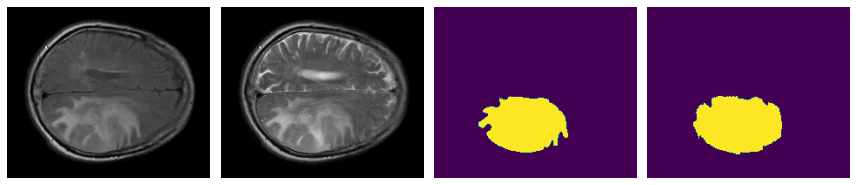

EGD-0004
(3, 189, 233, 197)
(197, 233)
(197, 233, 189, 3)
[0. 1.]
[0 1]


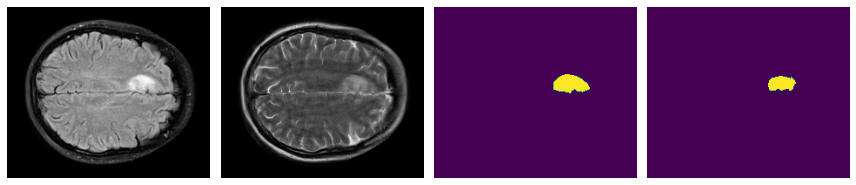

EGD-0006
(3, 189, 233, 197)
(197, 233)
(197, 233, 189, 3)
[0. 1.]
[0 1]


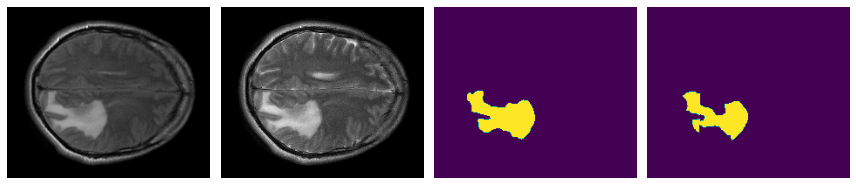

EGD-0009
(3, 189, 233, 197)
(197, 233)
(197, 233, 189, 3)
[0. 1.]
[0 1]


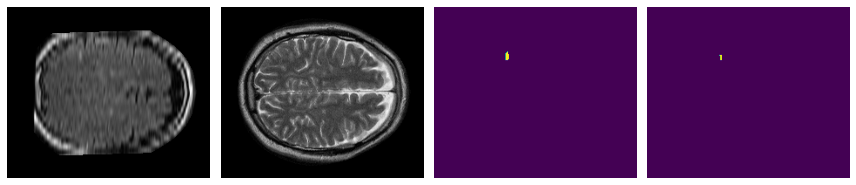

EGD-0014
(3, 189, 233, 197)
(197, 233)
(197, 233, 189, 3)
[0. 1.]
[0 1]


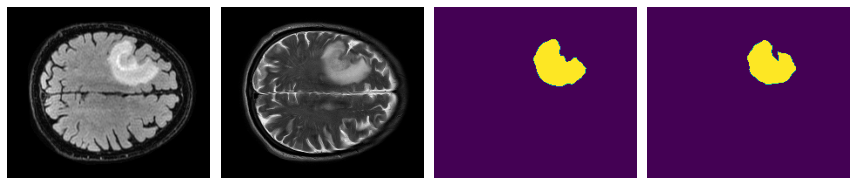

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

n, z = 5, 107
data = sorted(glob("/results/erasmus_infer/fold-0_brats/predictions_epoch=135-dice_mean=90_62_task=11_fold=0_tta/*.npz"))
for i in range(n):
    fname = data[i].split("/")[-1].split(".")[0]
    print(fname)
    img = nib.load(f"/data/EGD_train/images/{fname}.nii.gz").get_fdata().astype(np.float32)
    label = nib.load(f"/data/EGD_train/labels/{fname}_seg.nii.gz").get_fdata().astype(np.uint8)[:, :, z]
    pred = np.load(data[i])['arr_0']
#     pred = to_lbl(pred)[:, :, z]
    print(pred.shape)
    pred = np.round(pred, 0).transpose(3,2,1,0)
    print(label.shape), print(pred.shape)
    print(np.unique(pred)), print(np.unique(label))
    imgs = [img[:, :, z, i] for i in [0, 3]] + [pred[:,:,z,0].astype('uint8') ] + [label]    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))
    for i in range(4):
        if i < 2:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()

In [31]:
!cd /results/erasmus_infer  && ls

fold-0_brats  fold-1_brats  fold-2_brats
